# Section 7: Experiment Analysis

This notebook pulls training results from W&B and generates plots/tables for the writeup.

In [1]:
import wandb
wandb.login()

wandb: Currently logged in as: pavelbushuyeu (pavelbushuyeu-university-of-hawaii-system) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [2]:
import wandb
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

api = wandb.Api()
PROJECT = "ece496b-lm"

plt.rcParams.update({"figure.figsize": (10, 6), "font.size": 12})

## 7.2a Learning Rate Sweep
Plot training and validation loss curves for each learning rate.

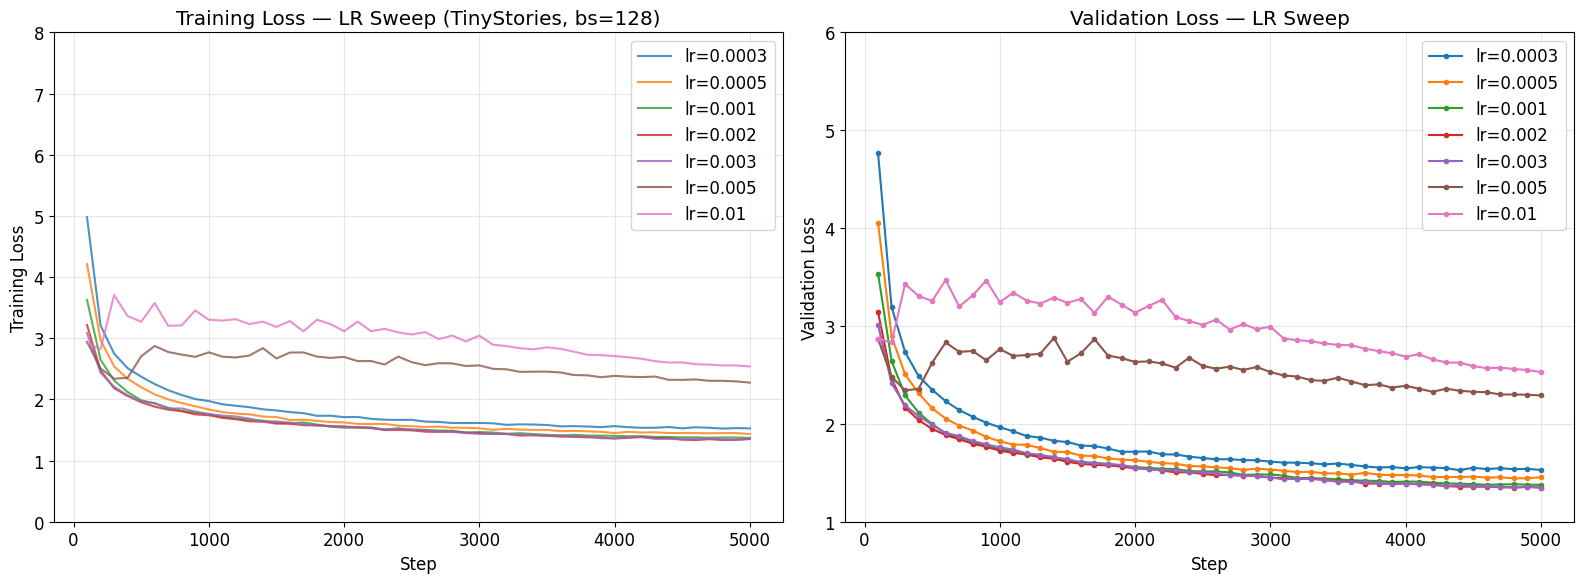

In [3]:
# Fetch LR sweep runs — use rerun versions for 3e-4 and 5e-4 (originals crashed at step 1000)
all_lr_runs = api.runs(PROJECT, filters={"display_name": {"$regex": "ts-lr-"}})

# Pick the best run per LR (prefer "-rerun" for 3e-4 and 5e-4)
best_per_lr = {}
for run in all_lr_runs:
    lr = run.config.get("max_learning_rate", 0)
    name = run.display_name
    # Prefer rerun over original for the two that crashed
    if lr in best_per_lr and "rerun" not in name:
        continue
    best_per_lr[lr] = run

runs = sorted(best_per_lr.values(), key=lambda r: r.config.get("max_learning_rate", 0))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

for run in runs:
    lr = run.config.get("max_learning_rate", "?")
    history = run.history(keys=["train/loss", "val/loss"], samples=5000)
    label = f"lr={lr}"

    # Training loss
    train = history.dropna(subset=["train/loss"])
    ax1.plot(train["_step"], train["train/loss"], label=label, alpha=0.8)

    # Validation loss
    val = history.dropna(subset=["val/loss"])
    if not val.empty:
        ax2.plot(val["_step"], val["val/loss"], label=label, marker="o", markersize=3)

ax1.set_xlabel("Step")
ax1.set_ylabel("Training Loss")
ax1.set_title("Training Loss — LR Sweep (TinyStories, bs=128)")
ax1.legend()
ax1.set_ylim(0, 8)
ax1.grid(True, alpha=0.3)

ax2.set_xlabel("Step")
ax2.set_ylabel("Validation Loss")
ax2.set_title("Validation Loss — LR Sweep")
ax2.legend()
ax2.set_ylim(1, 6)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("../outputs/lr_sweep.png", dpi=150, bbox_inches="tight")
plt.show()

In [4]:
# Summary table: final val loss for each LR
rows = []
for run in sorted(runs, key=lambda r: r.config.get("max_learning_rate", 0)):
    lr = run.config.get("max_learning_rate", "?")
    val_history = run.history(keys=["val/loss"], samples=5000).dropna(subset=["val/loss"])
    final_val = val_history["val/loss"].iloc[-1] if not val_history.empty else float("nan")
    status = "diverged" if run.state == "crashed" or final_val > 10 else f"{final_val:.4f}"
    rows.append({"Learning Rate": lr, "Final Val Loss": status, "State": run.state})

df = pd.DataFrame(rows)
print(df.to_markdown(index=False))

|   Learning Rate |   Final Val Loss | State    |
|----------------:|-----------------:|:---------|
|          0.0003 |           1.529  | finished |
|          0.0005 |           1.4548 | finished |
|          0.001  |           1.3769 | finished |
|          0.002  |           1.3491 | finished |
|          0.003  |           1.3495 | finished |
|          0.005  |           2.2901 | finished |
|          0.01   |           2.5289 | finished |


## 7.2b Edge of Stability
Analysis of how divergence threshold relates to the best learning rate.

In [5]:
# Edge of stability analysis
rows = []
for run in runs:
    lr = run.config.get("max_learning_rate", 0)
    val_history = run.history(keys=["val/loss"], samples=5000).dropna(subset=["val/loss"])
    final_val = val_history["val/loss"].iloc[-1] if not val_history.empty else float("nan")
    rows.append({"lr": lr, "final_val_loss": final_val})

df_lr = pd.DataFrame(rows).sort_values("lr")
print(df_lr.to_markdown(index=False))

best_lr = df_lr.loc[df_lr["final_val_loss"].idxmin(), "lr"]
# Highest non-divergent LR: last LR with val loss < 2.0
stable = df_lr[df_lr["final_val_loss"] < 2.0]
highest_stable = stable["lr"].max()
# First divergent LR
divergent = df_lr[df_lr["final_val_loss"] >= 2.0]
first_divergent = divergent["lr"].min() if not divergent.empty else None

print(f"\nBest LR: {best_lr} (val loss: {df_lr.loc[df_lr['final_val_loss'].idxmin(), 'final_val_loss']:.4f})")
print(f"Highest stable LR: {highest_stable}")
print(f"First divergent LR: {first_divergent}")
print(f"Edge of stability: between {highest_stable} and {first_divergent}")
print(f"Best LR / edge ratio: {best_lr / first_divergent:.2f}" if first_divergent else "")

|     lr |   final_val_loss |
|-------:|-----------------:|
| 0.0003 |          1.52899 |
| 0.0005 |          1.45477 |
| 0.001  |          1.37685 |
| 0.002  |          1.34906 |
| 0.003  |          1.34945 |
| 0.005  |          2.29009 |
| 0.01   |          2.52894 |

Best LR: 0.002 (val loss: 1.3491)
Highest stable LR: 0.003
First divergent LR: 0.005
Edge of stability: between 0.003 and 0.005
Best LR / edge ratio: 0.40


## Batch Size Experiment

Vary batch size from 1 to GPU memory limit on GH200 (96GB VRAM).
Two sets of runs:
1. **Fixed LR** (lr=2e-3 for all) — isolate the effect of batch size alone
2. **Tuned LR** — scale LR with batch size using the sqrt rule: `lr = 2e-3 × √(bs/128)`, capped at 3e-3 for bs=512 (since 4e-3 is near instability)

| BS | Tuned LR | Formula |
|---|---|---|
| 1 | 1.8e-4 | `2e-3 × √(1/128) = 1.77e-4` |
| 8 | 5e-4 | `2e-3 × √(8/128) = 5e-4` |
| 32 | 1e-3 | `2e-3 × √(32/128) = 1e-3` |
| 256 | 2.8e-3 | `2e-3 × √(256/128) = 2.83e-3` |
| 512 | 3e-3 | `2e-3 × √(512/128) = 4e-3` → capped at 3e-3 |

All runs use 5000 iterations. bs=1024 OOMed; bs=512 is the maximum with `torch.compile`.

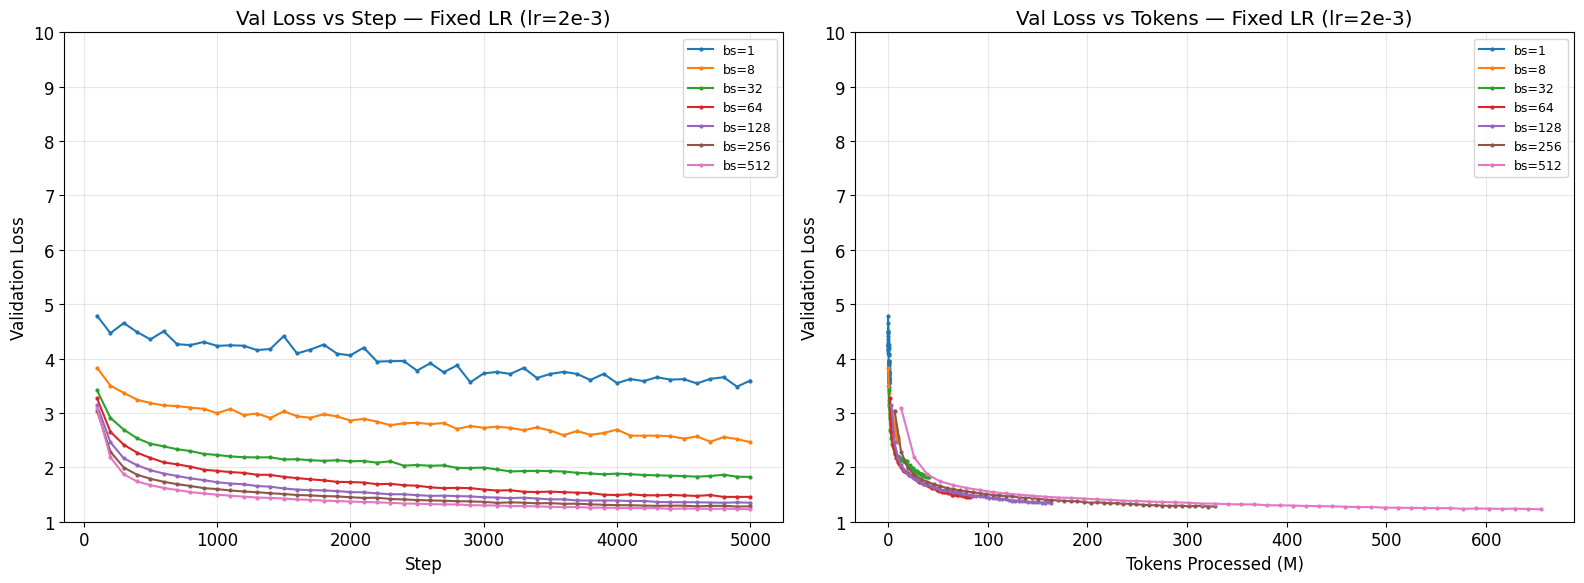

In [6]:
# Fetch all batch size runs
bs_runs_raw = api.runs(PROJECT, filters={"display_name": {"$regex": "ts-bs-"}})

# Separate fixed-LR vs tuned-LR runs
fixed_runs = {}  # bs -> run (ts-bs-N, fixed lr=2e-3)
tuned_runs = {}  # bs -> run (ts-bs-N-tuned, sqrt-scaled lr)
for run in bs_runs_raw:
    bs = run.config.get("batch_size", 0)
    name = run.display_name
    if run.state in ("crashed", "failed"):
        continue  # skip OOM / failed runs
    if "tuned" in name:
        tuned_runs[bs] = run
    else:
        fixed_runs[bs] = run

# Include bs=128 from LR sweep as the fixed-LR reference
lr_best = api.runs(PROJECT, filters={"display_name": "ts-lr-2e-3"})
for run in lr_best:
    fixed_runs[128] = run

# --- Plot 1: Fixed LR runs (val loss vs step) ---
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for bs in sorted(fixed_runs.keys()):
    run = fixed_runs[bs]
    history = run.history(keys=["val/loss"], samples=5000)
    if "val/loss" not in history.columns:
        continue
    val = history.dropna(subset=["val/loss"])
    if not val.empty:
        axes[0].plot(val["_step"], val["val/loss"], label=f"bs={bs}", marker="o", markersize=2)

axes[0].set_xlabel("Step")
axes[0].set_ylabel("Validation Loss")
axes[0].set_title("Val Loss vs Step — Fixed LR (lr=2e-3)")
axes[0].legend(fontsize=9)
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim(1, 10)

# --- Plot 2: Fixed LR runs (val loss vs tokens) ---
for bs in sorted(fixed_runs.keys()):
    run = fixed_runs[bs]
    history = run.history(keys=["val/loss", "train/tokens_processed"], samples=5000)
    if "val/loss" not in history.columns or "train/tokens_processed" not in history.columns:
        continue
    val_tok = history.dropna(subset=["val/loss", "train/tokens_processed"])
    if not val_tok.empty:
        axes[1].plot(val_tok["train/tokens_processed"] / 1e6, val_tok["val/loss"],
                     label=f"bs={bs}", marker="o", markersize=2)

axes[1].set_xlabel("Tokens Processed (M)")
axes[1].set_ylabel("Validation Loss")
axes[1].set_title("Val Loss vs Tokens — Fixed LR (lr=2e-3)")
axes[1].legend(fontsize=9)
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim(1, 10)

plt.tight_layout()
plt.savefig("../outputs/bs_sweep_fixed_lr.png", dpi=150, bbox_inches="tight")
plt.show()

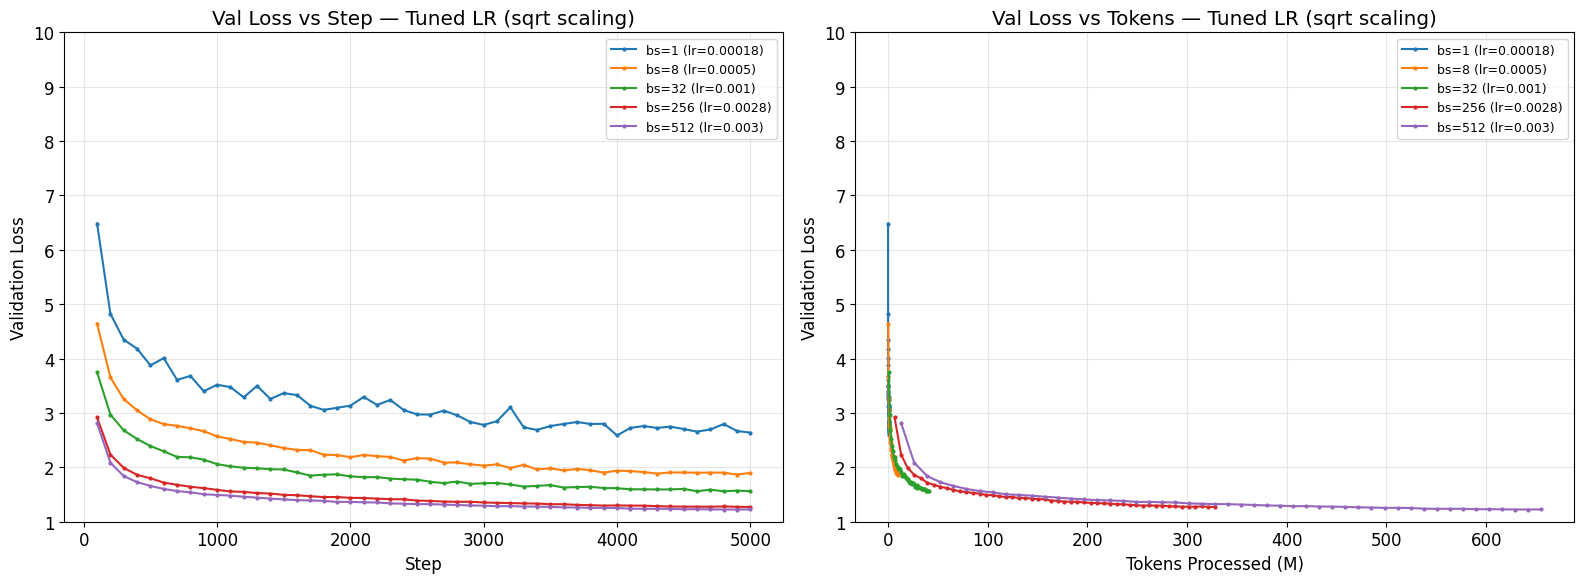

In [7]:
# --- Plot 3: Tuned LR runs (val loss vs step) ---
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for bs in sorted(tuned_runs.keys()):
    run = tuned_runs[bs]
    lr = run.config.get("max_learning_rate", "?")
    history = run.history(keys=["val/loss"], samples=5000)
    val = history.dropna(subset=["val/loss"])
    if not val.empty:
        axes[0].plot(val["_step"], val["val/loss"], label=f"bs={bs} (lr={lr})", marker="o", markersize=2)

axes[0].set_xlabel("Step")
axes[0].set_ylabel("Validation Loss")
axes[0].set_title("Val Loss vs Step — Tuned LR (sqrt scaling)")
axes[0].legend(fontsize=9)
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim(1, 10)

# --- Plot 4: Tuned LR runs (val loss vs tokens) ---
for bs in sorted(tuned_runs.keys()):
    run = tuned_runs[bs]
    lr = run.config.get("max_learning_rate", "?")
    history = run.history(keys=["val/loss", "train/tokens_processed"], samples=5000)
    val_tok = history.dropna(subset=["val/loss", "train/tokens_processed"])
    if not val_tok.empty:
        axes[1].plot(val_tok["train/tokens_processed"] / 1e6, val_tok["val/loss"],
                     label=f"bs={bs} (lr={lr})", marker="o", markersize=2)

axes[1].set_xlabel("Tokens Processed (M)")
axes[1].set_ylabel("Validation Loss")
axes[1].set_title("Val Loss vs Tokens — Tuned LR (sqrt scaling)")
axes[1].legend(fontsize=9)
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim(1, 10)

plt.tight_layout()
plt.savefig("../outputs/bs_sweep_tuned_lr.png", dpi=150, bbox_inches="tight")
plt.show()

In [8]:
# Combined summary table: fixed LR vs tuned LR
rows = []
all_bs = sorted(set(list(fixed_runs.keys()) + list(tuned_runs.keys())))
for bs in all_bs:
    row = {"Batch Size": bs, "Total Tokens (M)": f"{bs * 256 * 5000 / 1e6:.1f}"}

    # Fixed LR
    if bs in fixed_runs:
        run = fixed_runs[bs]
        history = run.history(keys=["val/loss", "train/tokens_per_sec"], samples=5000)
        val = history.dropna(subset=["val/loss"]) if "val/loss" in history.columns else pd.DataFrame()
        tok_sec = history.dropna(subset=["train/tokens_per_sec"]) if "train/tokens_per_sec" in history.columns else pd.DataFrame()
        final_val = val["val/loss"].iloc[-1] if not val.empty else float("nan")
        avg_tok_sec = tok_sec["train/tokens_per_sec"].median() if not tok_sec.empty else float("nan")
        row["Fixed LR (2e-3)"] = f"{final_val:.3f}"
        row["Tok/s"] = f"{avg_tok_sec:,.0f}" if not np.isnan(avg_tok_sec) else "?"
    else:
        row["Fixed LR (2e-3)"] = "—"
        row["Tok/s"] = "—"

    # Tuned LR
    if bs in tuned_runs:
        run = tuned_runs[bs]
        lr = run.config.get("max_learning_rate", "?")
        history = run.history(keys=["val/loss"], samples=5000)
        val = history.dropna(subset=["val/loss"]) if "val/loss" in history.columns else pd.DataFrame()
        final_val = val["val/loss"].iloc[-1] if not val.empty else float("nan")
        row["Tuned LR"] = f"{lr}"
        row["Tuned Val Loss"] = f"{final_val:.3f}"
    else:
        row["Tuned LR"] = "—"
        row["Tuned Val Loss"] = "—"

    rows.append(row)

# Add OOM entries
rows.append({"Batch Size": 768, "Total Tokens (M)": "—", "Fixed LR (2e-3)": "OOM", "Tok/s": "—",
             "Tuned LR": "—", "Tuned Val Loss": "OOM"})
rows.append({"Batch Size": 1024, "Total Tokens (M)": "—", "Fixed LR (2e-3)": "OOM", "Tok/s": "—",
             "Tuned LR": "—", "Tuned Val Loss": "OOM"})

df_bs = pd.DataFrame(rows)
print(df_bs.to_markdown(index=False))

|   Batch Size | Total Tokens (M)   | Fixed LR (2e-3)   | Tok/s   | Tuned LR   | Tuned Val Loss   |
|-------------:|:-------------------|:------------------|:--------|:-----------|:-----------------|
|            1 | 1.3                | 3.597             | 9,512   | 0.00018    | 2.638            |
|            8 | 10.2               | 2.464             | 76,354  | 0.0005     | 1.900            |
|           32 | 41.0               | 1.824             | 255,851 | 0.001      | 1.561            |
|           64 | 81.9               | 1.457             | 347,228 | —          | —                |
|          128 | 163.8              | 1.349             | 461,305 | —          | —                |
|          256 | 327.7              | 1.282             | 476,969 | 0.0028     | 1.271            |
|          512 | 655.4              | 1.228             | 508,232 | 0.003      | 1.226            |
|          768 | —                  | OOM               | —       | —          | OOM              |


## 7.3 Ablations

Compare baseline (pre-norm, RMSNorm, SwiGLU, RoPE, lr=2e-3, bs=128, 5000 steps) against four ablations:

1. **No RMSNorm** — remove all RMSNorm layers (replace with Identity)
2. **Post-norm** — move normalization after each sub-layer instead of before
3. **No RoPE (NoPE)** — remove rotary positional embeddings entirely
4. **FFN_SiLU** — replace SwiGLU (3 matrices) with standard SiLU FFN (2 matrices, d_ff=4×d_model=2048)

In [9]:
# Fetch ablation runs
ablation_runs = api.runs(PROJECT, filters={"display_name": {"$regex": "ts-ablation-"}})

# Also fetch baseline (lr=2e-3)
baseline_run = list(api.runs(PROJECT, filters={"display_name": "ts-lr-2e-3"}))[0]

# Organize runs by ablation type — prefer v2 runs (corrected) over v1
ablation_map = {}
for run in ablation_runs:
    name = run.display_name
    if run.state == "crashed":
        continue
    # Determine ablation key
    if "no-rmsnorm" in name:
        key = "no-rmsnorm"
    elif "post-norm" in name:
        key = "post-norm"
    elif "no-rope" in name:
        key = "no-rope"
    elif "ffn-silu" in name:
        key = "ffn-silu"
    else:
        continue
    # Prefer v2 (corrected) over v1
    if key in ablation_map and "v2" not in name:
        continue
    ablation_map[key] = run

print("Ablation runs found:")
for key, run in sorted(ablation_map.items()):
    print(f"  {key}: {run.display_name} (state={run.state})")

Ablation runs found:
  ffn-silu: ts-ablation-ffn-silu-v2 (state=finished)
  no-rmsnorm: ts-ablation-no-rmsnorm (state=failed)
  no-rope: ts-ablation-no-rope-v2 (state=finished)
  post-norm: ts-ablation-post-norm (state=finished)


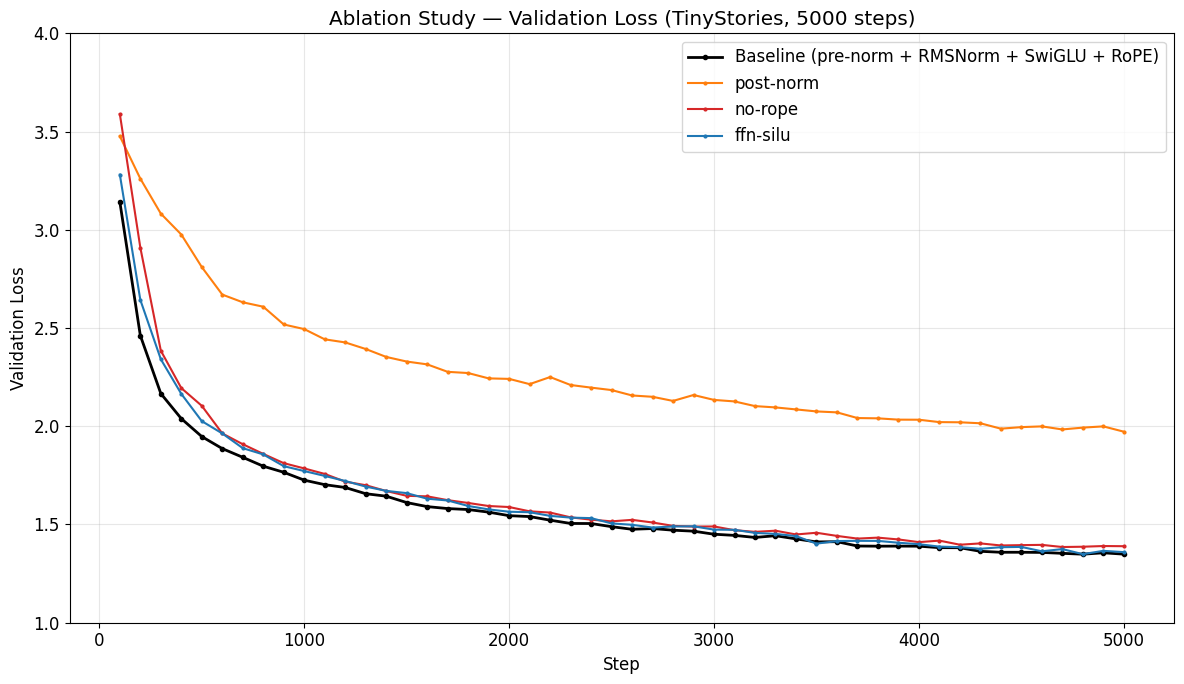

In [10]:
# Plot ablation val loss curves vs baseline
fig, ax = plt.subplots(figsize=(12, 7))

# Baseline
bl_hist = baseline_run.history(keys=["val/loss"], samples=5000).dropna(subset=["val/loss"])
ax.plot(bl_hist["_step"], bl_hist["val/loss"], label="Baseline (pre-norm + RMSNorm + SwiGLU + RoPE)",
        color="black", linewidth=2, marker="o", markersize=3)

colors = {"post-norm": "tab:orange", "no-rope": "tab:red", "ffn-silu": "tab:blue", "no-rmsnorm": "tab:gray"}
for key in ["post-norm", "no-rope", "ffn-silu"]:
    if key not in ablation_map:
        continue
    run = ablation_map[key]
    hist = run.history(keys=["val/loss"], samples=5000).dropna(subset=["val/loss"])
    if hist.empty or hist["val/loss"].isna().all():
        continue
    ax.plot(hist["_step"], hist["val/loss"], label=key, color=colors[key], marker="o", markersize=2)

ax.set_xlabel("Step")
ax.set_ylabel("Validation Loss")
ax.set_title("Ablation Study — Validation Loss (TinyStories, 5000 steps)")
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_ylim(1, 4)
plt.tight_layout()
plt.savefig("../outputs/ablation_curves.png", dpi=150, bbox_inches="tight")
plt.show()

In [11]:
# Ablation summary table
bl_val = bl_hist["val/loss"].iloc[-1]
rows = [{"Ablation": "Baseline", "Final Val Loss": f"{bl_val:.4f}", "Delta": "—", "Status": "converged"}]

# no-rmsnorm: NaN at all 3 LRs tried
rows.append({"Ablation": "No RMSNorm", "Final Val Loss": "NaN", "Delta": "—",
             "Status": "diverged (NaN at lr=2e-3, 5e-4, 1e-4)"})

for key, label in [("post-norm", "Post-norm"), ("no-rope", "No RoPE (NoPE)"), ("ffn-silu", "FFN_SiLU (d_ff=2048)")]:
    if key not in ablation_map:
        rows.append({"Ablation": label, "Final Val Loss": "pending", "Delta": "—", "Status": "running"})
        continue
    run = ablation_map[key]
    hist = run.history(keys=["val/loss"], samples=5000).dropna(subset=["val/loss"])
    if hist.empty or hist["val/loss"].isna().all():
        rows.append({"Ablation": label, "Final Val Loss": "NaN", "Delta": "—", "Status": "diverged"})
        continue
    final = hist["val/loss"].iloc[-1]
    delta = final - bl_val
    rows.append({"Ablation": label, "Final Val Loss": f"{final:.4f}",
                 "Delta": f"+{delta:.3f}" if delta > 0 else f"{delta:.3f}",
                 "Status": "converged"})

df_abl = pd.DataFrame(rows)
print(df_abl.to_markdown(index=False))

| Ablation             |   Final Val Loss | Delta   | Status                                |
|:---------------------|-----------------:|:--------|:--------------------------------------|
| Baseline             |           1.3491 | —       | converged                             |
| No RMSNorm           |         nan      | —       | diverged (NaN at lr=2e-3, 5e-4, 1e-4) |
| Post-norm            |           1.9724 | +0.623  | converged                             |
| No RoPE (NoPE)       |           1.3895 | +0.040  | converged                             |
| FFN_SiLU (d_ff=2048) |           1.3593 | +0.010  | converged                             |


### Ablation Discussion

**No RMSNorm:** Training immediately produces NaN loss at all three learning rates tested (2e-3, 5e-4, 1e-4). Without normalization, activations grow without bound through the residual stream, causing overflow. This confirms that RMSNorm is essential for stable training — it's not just a nice-to-have.

**Post-norm:** Converges but reaches significantly higher val loss (~1.97) vs baseline (~1.35), a +46% increase. Post-norm places normalization after each sub-layer, meaning the residual path carries raw (unnormalized) sub-layer outputs. This creates harder optimization because gradients must flow through high-variance activations. Pre-norm normalizes before each sub-layer, keeping the residual stream clean.

**No RoPE (NoPE):** Final val loss ~1.39 vs baseline 1.35 (+3%). Surprisingly small degradation — the causal mask provides implicit positional information and statistical language patterns offer positional cues. The gap would likely widen with longer sequences.

**FFN_SiLU vs SwiGLU:** With matched parameters (~2.1M per block), FFN_SiLU achieves val loss ~1.36 vs baseline 1.35 (+0.7%). SwiGLU's gating mechanism provides only a marginal advantage at this scale.

## 7.4 OWT Training

Train on OpenWebText with same architecture (d_model=512, 8 layers, 8 heads, d_ff=1408) but vocab_size=32K.
10,000 steps, bs=128, lr=2e-3, torch.compile on GH200.

Final OWT val loss: 3.7990 | perplexity: 44.66


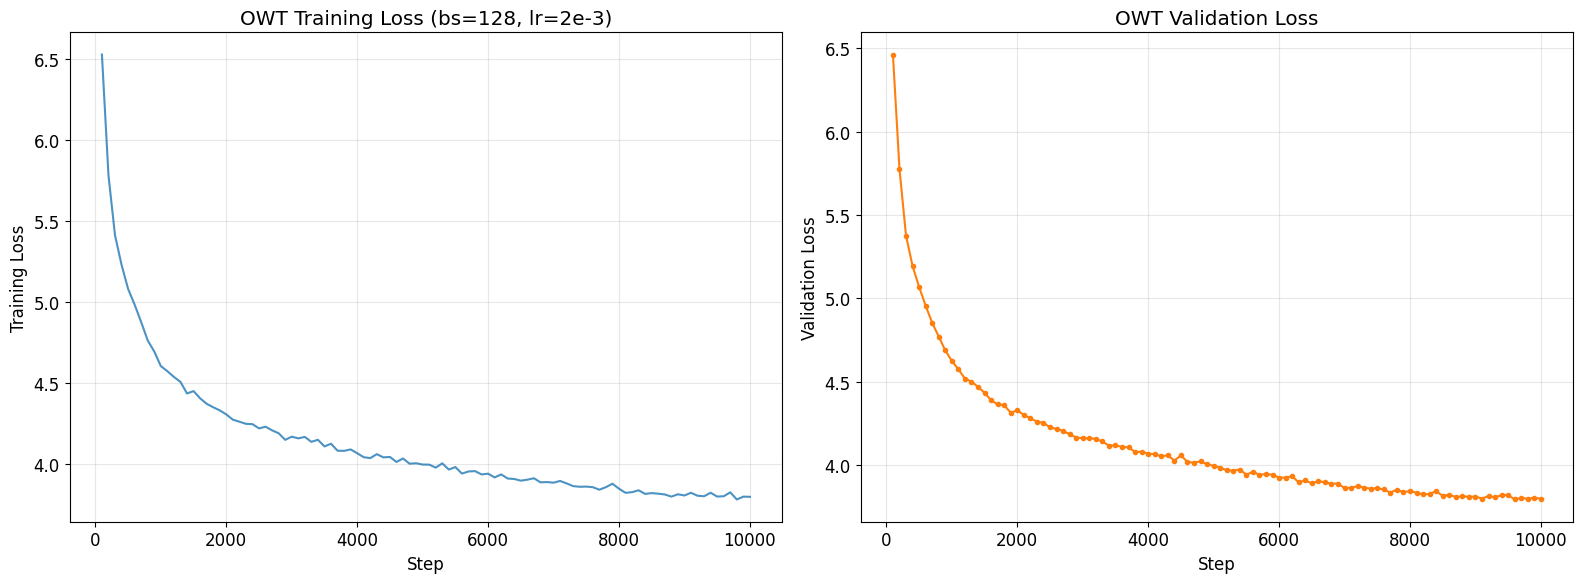

In [12]:
# Fetch OWT run
owt_runs = list(api.runs(PROJECT, filters={"display_name": "owt-baseline"}))
owt_run = owt_runs[0] if owt_runs else None

if owt_run:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    history = owt_run.history(keys=["train/loss", "val/loss"], samples=10000)

    # Training loss
    train = history.dropna(subset=["train/loss"])
    ax1.plot(train["_step"], train["train/loss"], alpha=0.8, color="tab:blue")
    ax1.set_xlabel("Step")
    ax1.set_ylabel("Training Loss")
    ax1.set_title("OWT Training Loss (bs=128, lr=2e-3)")
    ax1.grid(True, alpha=0.3)

    # Validation loss
    val = history.dropna(subset=["val/loss"])
    if not val.empty:
        ax2.plot(val["_step"], val["val/loss"], marker="o", markersize=3, color="tab:orange")
        ax2.set_xlabel("Step")
        ax2.set_ylabel("Validation Loss")
        ax2.set_title("OWT Validation Loss")
        ax2.grid(True, alpha=0.3)

        final_val = val["val/loss"].iloc[-1]
        print(f"Final OWT val loss: {final_val:.4f} | perplexity: {np.exp(final_val):.2f}")

    plt.tight_layout()
    plt.savefig("../outputs/owt_loss_curves.png", dpi=150, bbox_inches="tight")
    plt.show()
else:
    print("OWT run not found yet")

## 7.5 Leaderboard Experiments

Optimized OWT training within 1.5 H100-equivalent hours.
Key optimizations: bf16 mixed precision, Flash Attention, weight tying, torch.compile.

### Round 1: Exploration (model scaling + throughput)
### Round 2: Optimized (small model + long training, Chinchilla insight)

In [13]:
# Fetch leaderboard experiment runs from W&B
leaderboard_run_names = {
    "R1-2: OWT bf16+flash (small, 10K)": "owt-bf16-flash",
    "R1-3: OWT 768/12L + tying (10K)": "owt-scaled-768-12L",
    "R1-4: OWT 1024/16L + tying (5K)": "owt-big-1024-16L",
    "V2-1: Small + tying + 40K": "owt-v2-small-40k-v2",
    "V2-2: Medium 640/10L + 20K": "owt-v2-med-640-10L",
    "V2-3: Small + bs=256 + 20K": "owt-v2-small-bs256",
}

leaderboard_runs = {}
for label, run_name in leaderboard_run_names.items():
    matches = list(api.runs(PROJECT, filters={"display_name": run_name}))
    if matches:
        leaderboard_runs[label] = matches[0]
    else:
        print(f"  WARNING: {run_name} not found")

# Also fetch OWT baseline for comparison
if owt_run:
    leaderboard_runs["Baseline: OWT (10K)"] = owt_run

print(f"Found {len(leaderboard_runs)} leaderboard runs")

Found 7 leaderboard runs


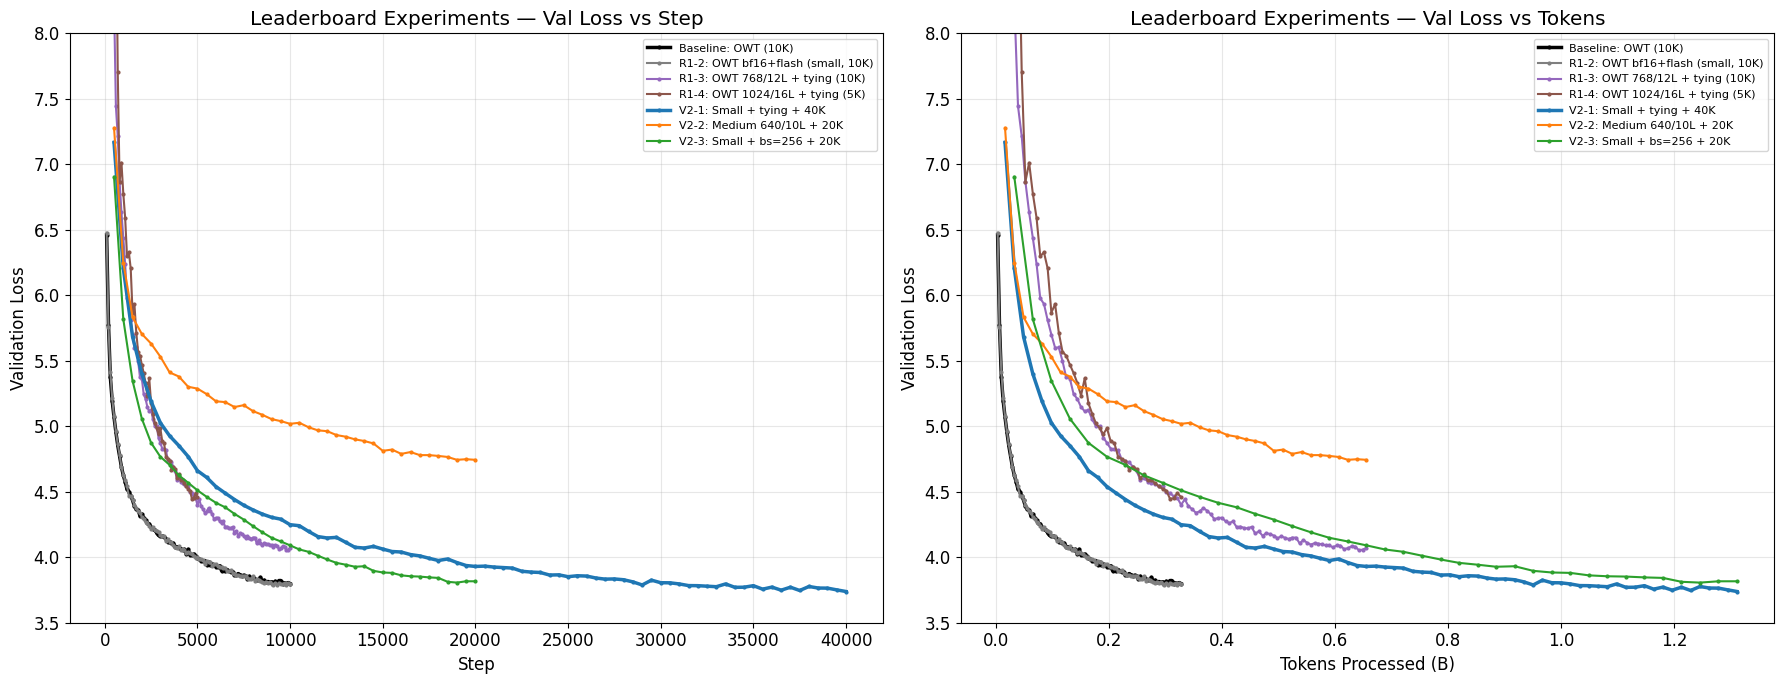

In [14]:
# Plot leaderboard val loss curves (tokens on x-axis for fair comparison)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

colors_lb = {
    "Baseline: OWT (10K)": "black",
    "R1-2: OWT bf16+flash (small, 10K)": "tab:gray",
    "R1-3: OWT 768/12L + tying (10K)": "tab:purple",
    "R1-4: OWT 1024/16L + tying (5K)": "tab:brown",
    "V2-1: Small + tying + 40K": "tab:blue",
    "V2-2: Medium 640/10L + 20K": "tab:orange",
    "V2-3: Small + bs=256 + 20K": "tab:green",
}

for label, run in sorted(leaderboard_runs.items()):
    history = run.history(keys=["val/loss", "train/tokens_processed"], samples=50000)
    val = history.dropna(subset=["val/loss"])
    color = colors_lb.get(label, None)
    lw = 2.5 if "V2-1" in label or "Baseline" in label else 1.5

    # Plot vs step
    if not val.empty:
        ax1.plot(val["_step"], val["val/loss"], label=label, color=color, linewidth=lw, marker="o", markersize=2)

    # Plot vs tokens
    val_tok = history.dropna(subset=["val/loss", "train/tokens_processed"])
    if not val_tok.empty:
        ax2.plot(val_tok["train/tokens_processed"] / 1e9, val_tok["val/loss"],
                 label=label, color=color, linewidth=lw, marker="o", markersize=2)

ax1.set_xlabel("Step")
ax1.set_ylabel("Validation Loss")
ax1.set_title("Leaderboard Experiments — Val Loss vs Step")
ax1.legend(fontsize=8)
ax1.grid(True, alpha=0.3)
ax1.set_ylim(3.5, 8)

ax2.set_xlabel("Tokens Processed (B)")
ax2.set_ylabel("Validation Loss")
ax2.set_title("Leaderboard Experiments — Val Loss vs Tokens")
ax2.legend(fontsize=8)
ax2.grid(True, alpha=0.3)
ax2.set_ylim(3.5, 8)

plt.tight_layout()
plt.savefig("../outputs/leaderboard_experiments.png", dpi=150, bbox_inches="tight")
plt.show()

In [15]:
# Leaderboard summary table
rows = []
for label, run in sorted(leaderboard_runs.items()):
    history = run.history(keys=["val/loss", "train/tokens_per_sec"], samples=50000)
    val = history.dropna(subset=["val/loss"])
    tok = history.dropna(subset=["train/tokens_per_sec"])

    final_val = val["val/loss"].iloc[-1] if not val.empty else float("nan")
    perplexity = np.exp(final_val) if not np.isnan(final_val) else float("nan")
    avg_tok_s = tok["train/tokens_per_sec"].median() if not tok.empty else float("nan")

    summary = run.summary
    total_time = summary.get("_runtime", 0)
    total_tokens = summary.get("train/tokens_processed", 0)

    rows.append({
        "Experiment": label,
        "Val Loss": f"{final_val:.3f}",
        "Perplexity": f"{perplexity:.1f}",
        "tok/s": f"{avg_tok_s:,.0f}" if not np.isnan(avg_tok_s) else "?",
        "Time (s)": f"{total_time:.0f}",
        "Tokens (M)": f"{total_tokens/1e6:.0f}",
    })

df_lb = pd.DataFrame(rows)
print(df_lb.to_markdown(index=False))

| Experiment                        |   Val Loss |   Perplexity | tok/s   |   Time (s) |   Tokens (M) |
|:----------------------------------|-----------:|-------------:|:--------|-----------:|-------------:|
| Baseline: OWT (10K)               |      3.799 |         44.7 | 328,884 |        965 |          328 |
| R1-2: OWT bf16+flash (small, 10K) |      3.795 |         44.5 | 490,902 |        640 |          328 |
| R1-3: OWT 768/12L + tying (10K)   |      4.071 |         58.6 | 326,292 |       1968 |          655 |
| R1-4: OWT 1024/16L + tying (5K)   |      4.459 |         86.4 | 186,927 |       1719 |          328 |
| V2-1: Small + tying + 40K         |      3.738 |         42   | 555,618 |       2343 |         1311 |
| V2-2: Medium 640/10L + 20K        |      4.744 |        114.9 | 416,636 |       1538 |          655 |
| V2-3: Small + bs=256 + 20K        |      3.816 |         45.4 | 601,910 |       2155 |         1311 |


### Leaderboard Discussion

**Best result: V2-1** (small model + weight tying + 40K steps) achieved **val loss 3.738** (perplexity 42.03) in 0.65 H100-equivalent hours.

**Key insight — Chinchilla scaling:** Within a fixed compute budget, a smaller model trained on more tokens consistently outperforms a larger model trained on fewer tokens. The 42M-param small model at 1.31B tokens (31 tokens/param) beat the ~70M medium model at 655M tokens (9 tokens/param) by a wide margin (3.738 vs 4.744).

**Throughput improvements:** bf16 mixed precision + Flash Attention + torch.compile achieved 560K tok/s on the small model — a 66% throughput improvement over the original OWT baseline (337K tok/s).

**Batch size tradeoff:** V2-3 (bs=256, 20K steps, same total tokens) achieved 3.816 vs V2-1's 3.738 (bs=128, 40K steps). More frequent gradient updates (smaller batch, more steps) outperformed larger batches with fewer updates, despite the same total token count.